In [1]:
import re
import shap
import pickle
import pandas as pd
from scipy import sparse

import nltk
from nltk.corpus import stopwords 
nltk.download("stopwords")  
nltk.download('punkt')
nltk.download('wordnet')     
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def parse_single_input(description):
        description = re.sub("[^a-zA-Z]"," ",description)
        description = description.lower()   
        description = nltk.word_tokenize(description)
        lemma = nltk.WordNetLemmatizer()
        description = [ lemma.lemmatize(word) for word in description]
        description = " ".join(description)
        return description

# SHAP 

In [3]:
input_score = 3
input_review = "The calendar doesn’t work and has to be reset every day. The leather band is so stiff and hard to put on. I have even used olive oil to soften it. I have to reset the time everyday. Not very pleased with this watch. I thought for the price it would be much better."

In [4]:
vectorizer = pickle.load(open('vectorizer.pk', 'rb'))

In [5]:
model = pickle.load(open('prediction_model.sav', 'rb'))

In [6]:
x_train = sparse.load_npz("x_train.npz")

In [7]:
new_x = parse_single_input(input_review)
new_y = input_score

In [8]:
input_array = []
input_array.append(new_x)
new_result = vectorizer.transform(input_array)

In [9]:
new_prediction = model.predict(new_result)

In [10]:
print('Original Review Text:', input_review)
print('Actual score:', new_y)
print('Predicted:', new_prediction[0])

Original Review Text: The calendar doesn’t work and has to be reset every day. The leather band is so stiff and hard to put on. I have even used olive oil to soften it. I have to reset the time everyday. Not very pleased with this watch. I thought for the price it would be much better.
Actual score: 3
Predicted: 3.271752202394701


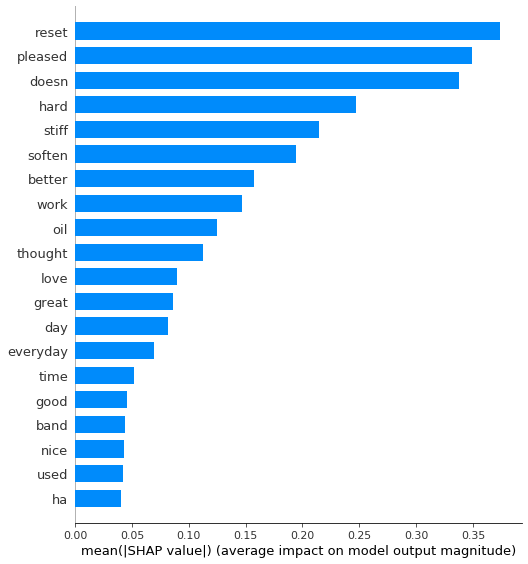

In [11]:
explainer = shap.LinearExplainer(model, x_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(new_result)
shap.summary_plot(shap_values, new_result, feature_names=vectorizer.get_feature_names(), plot_type="bar")

In [12]:
shap.initjs()
shap.force_plot(
    explainer.expected_value, shap_values, new_result.toarray(),
    feature_names=vectorizer.get_feature_names()
)

In [13]:
df_shap = pd.DataFrame({'shap': explainer.shap_values(new_result)[0], 'term': vectorizer.get_feature_names(), 'occurrence': new_result.toarray()[0]})

In [14]:
#df_occ = pd.DataFrame({'occ': new_result.toarray()[0], 'term': vectorizer.get_feature_names()})
#df_occ = df_occ.sort_values(by=['occ'],ascending=False)
#df_occ.head()

In [15]:
df_shap_lower = df_shap.sort_values(by=['shap'],ascending=True).head(10)
df_shap_lower

,shap,term,occurrence
30037,-0.374091,reset,2
10725,-0.337524,doesn,1
16528,-0.247232,hard,1
34329,-0.214159,stiff,1
40522,-0.147199,work,1
36319,-0.112460,thought,1
21414,-0.089277,love,0
15937,-0.085919,great,0
8989,-0.081438,day,1
36510,-0.052075,time,1


In [16]:
df_shap_higher = df_shap.sort_values(by=['shap'],ascending=False).head(10)
df_shap_higher

,shap,term,occurrence
27004,0.349250,pleased,1
33325,0.194697,soften,1
3730,0.157651,better,1
24966,0.124413,oil,1
12521,0.069168,everyday,1
16294,0.039980,ha,1
4785,0.021261,broke,0
6072,0.019380,cheap,0
20567,0.019110,leather,1
21260,0.016670,look,0


In [17]:
df_result = pd.concat([df_shap_higher, df_shap_lower])

In [18]:
# Add new columns named 'orientation', 'factor' and 'size'
df_result['orientation'] = ["negative" if x < 0 else "positive" for x in df_result['shap']]
df_result['factor'] = [abs(x) for x in df_result['shap']]
df_result['size'] = 16
df_result = df_result[df_result.occurrence != 0]
df_result = df_result.sort_values(by=['factor'],ascending=False)
df_result

,shap,term,occurrence,orientation,factor,size
30037,-0.374091,reset,2,negative,0.374091,16
27004,0.349250,pleased,1,positive,0.349250,16
10725,-0.337524,doesn,1,negative,0.337524,16
16528,-0.247232,hard,1,negative,0.247232,16
34329,-0.214159,stiff,1,negative,0.214159,16
33325,0.194697,soften,1,positive,0.194697,16
3730,0.157651,better,1,positive,0.157651,16
40522,-0.147199,work,1,negative,0.147199,16
24966,0.124413,oil,1,positive,0.124413,16
36319,-0.112460,thought,1,negative,0.112460,16


In [19]:
# DICTIONARY
dict = { 0 : 16, 1 : 18, 2 : 20, 3 : 22, 4 : 24, 5: 26, 6 : 28, 7 : 30, 8 : 32, 9 : 34 }

# DETERMINE SIZE
max_value = df_result['factor'].head(1)
min_value = df_result['factor'].tail(1)
real_range = float(max_value) - float(min_value)
step = float(real_range) / 10

length = len(df_result)



In [20]:
for i in df_result.index:
    row = df_result.loc[i]
    value = row['factor']
    t = row["term"]
    occ = row["occurrence"]
    res = round (value / step)
    if (occ > 1):
        new_res = round((value / occ) / step)
        if (new_res > 0.0):
            res = new_res
        else:
            res = 1.0
    size = dict[int(res-1)]
    df_result["size"].loc[i] = size
    
df_result


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,shap,term,occurrence,orientation,factor,size
30037,-0.374091,reset,2,negative,0.374091,24
27004,0.349250,pleased,1,positive,0.349250,34
10725,-0.337524,doesn,1,negative,0.337524,34
16528,-0.247232,hard,1,negative,0.247232,28
34329,-0.214159,stiff,1,negative,0.214159,26
33325,0.194697,soften,1,positive,0.194697,24
3730,0.157651,better,1,positive,0.157651,22
40522,-0.147199,work,1,negative,0.147199,22
24966,0.124413,oil,1,positive,0.124413,22
36319,-0.112460,thought,1,negative,0.112460,20


In [21]:
print("[")
length = len(df_result.index)
for i in df_result.index:
    row = df_result.loc[i].to_json()
    if (length == 1):
        print(row)
    else:
        print(row, ",")
    length -= 1
print("]")    
    
# df_shap.to_csv('shapvalues.csv', sep=',', index=False)

[
{"shap":-0.374090989,"term":"reset","occurrence":2,"orientation":"negative","factor":0.374090989,"size":24} ,
{"shap":0.3492499413,"term":"pleased","occurrence":1,"orientation":"positive","factor":0.3492499413,"size":34} ,
{"shap":-0.3375237921,"term":"doesn","occurrence":1,"orientation":"negative","factor":0.3375237921,"size":34} ,
{"shap":-0.2472318519,"term":"hard","occurrence":1,"orientation":"negative","factor":0.2472318519,"size":28} ,
{"shap":-0.2141590593,"term":"stiff","occurrence":1,"orientation":"negative","factor":0.2141590593,"size":26} ,
{"shap":0.1946966884,"term":"soften","occurrence":1,"orientation":"positive","factor":0.1946966884,"size":24} ,
{"shap":0.157650836,"term":"better","occurrence":1,"orientation":"positive","factor":0.157650836,"size":22} ,
{"shap":-0.1471991312,"term":"work","occurrence":1,"orientation":"negative","factor":0.1471991312,"size":22} ,
{"shap":0.1244126108,"term":"oil","occurrence":1,"orientation":"positive","factor":0.1244126108,"size":22} 